In [1]:
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib widget

# Load experiment

In [6]:
data_dir = Path(r"P:\\")
plotsavedir = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\THstim_project\THactivation")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,tiparea,dist_CL,color
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300,TH,0.925338,tomato
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300,CP,1.494992,firebrick
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,1.286954,limegreen
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,1.435270,forestgreen
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,0.686477,violet


In [7]:
choose_sub = 4
exprow = all_subexp.iloc[choose_sub]
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

Experiment type: electrical stimulation
THstim_d1


Get coords for stim electrode

In [8]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
else:
    print('Stim electrode location file not found.')

In [9]:
stim_elec_data

{'surface': {'area': 'RSPagl1', 'ccf_coords': [258, 15, 195]},
 'tip': {'area': 'AV', 'ccf_coords': [243, 140, 189]}}

## Load other data

### Load stim log and simple log

In [10]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [11]:
simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
if os.path.exists(simple_log_file):
    simple_log = pd.read_csv(simple_log_file)
elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
    simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
else:
    print('No simple log found')

In [12]:
simple_log.head()

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,10,20,1401.91070,1421.91083,0
1,freq50Hz,20,20,1524.83939,1544.83952,0
2,freq50Hz,30,20,1675.01610,1695.01623,0
3,freq50Hz,40,20,1821.29232,1841.29245,0
4,freq50Hz,40,40,1967.67782,2007.67808,0


### Load pupil diameter, if it exists

In [13]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilR = pupildf.Largest_Radius.values
    ## smooth pupil diameter, then normalize ##
    sm_pupil = np.zeros_like(pupilR)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilR)-k-1):
        sm_pupil[i] = np.mean(pupilR[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilR[:k]
    sm_pupil[-k-1:] = pupilR[-k-1:]
    pupil = sm_pupil / np.mean(pupildf.Eye_Diameter.values)
    print('{:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilR)) / len(pupilR)) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')

0% of frames do not have good pupil measurements


In [14]:
np.mean(pupildf.Eye_Diameter.values)

351.65731166846786

### Load running

In [15]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

### Load isoflurane signal

In [16]:
iso_level, isots = exp.load_analog_iso()
iso_induction, iso_maintenance = exp.load_iso_times()
print(iso_induction[0])
iso_level = iso_level - np.mean(iso_level[isots < iso_induction[0]])

711.4380563546174


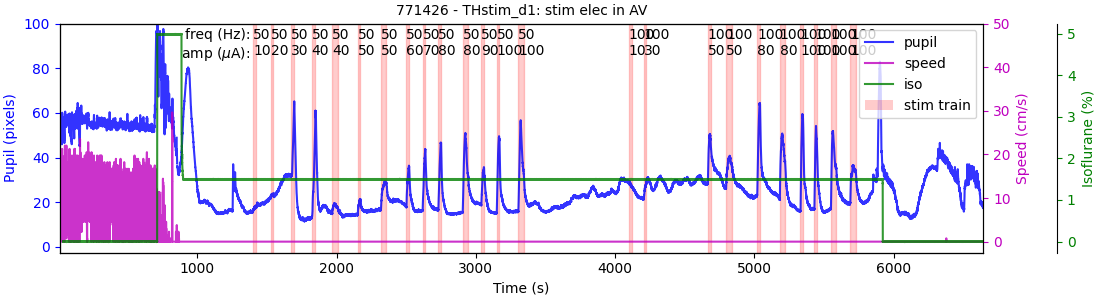

In [18]:
fig, ax = plt.subplots(figsize=(11,3), constrained_layout=True)
## Pupil ##
pup, = ax.plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
ax.set_xlim([pupilts[0], pupilts[-1]])
ax.set_ylim([-2.5, 100])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil (pixels)', color='b')
ax.tick_params(axis='y', colors='b')
## Add stim events ##
for ii, traini in simple_log.iterrows():
    ax.axvspan(traini.onset, traini.offset, color='r', alpha=0.2)
    etag = traini.stim_type[4:-2] + '\n' + str(traini.parameter)
    ax.annotate(etag, xy=(traini.onset, 98), xycoords='data', va='top')
    if ii == 0:
        ax.annotate('freq (Hz):\namp ($\mu$A):', xy=((traini.onset-20), 98), xycoords='data', va='top', ha='right')
spat = mpatches.Rectangle((0, 0), 1, 1, fc='r', alpha=0.2, label='stim train')
## Running ##
runax = ax.twinx()
run, = runax.plot(speedts, speed, color='m', alpha=0.8, label='speed')
runax.set_ylabel('Speed (cm/s)', color='m')
runax.tick_params(axis='y', colors='m')
runax.set_ylim([-2.5, 50])
## Iso level ##
isoax = ax.twinx()
isoax.spines.right.set_position(("axes", 1.08))
isp, = isoax.plot(isots, iso_level, color='g', alpha=0.8, label='iso')
isoax.set_ylabel('Isoflurane (%)', color='g')
isoax.tick_params(axis='y', colors='g')
## Set title and legend ##
ax.set_title('{} - {}: stim elec in {}'.format(exp.mouse, exp_tag, stim_elec_data['tip']['area']))
ax.legend(handles = [pup, run, isp, spat], loc='upper right')

### Load unit data

In [19]:
fn_units_info = os.path.join(exp.data_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region
0,A0,probeA,1,3640,0.535678,LSr,171,202,234,0.680991,0.93,2.081575,0.068689,4495,STR
1,A1,probeA,1,3640,0.439531,LSr,171,202,234,2.016461,0.91,0.000000,0.000020,13310,STR
2,A3,probeA,2,3620,0.631826,LSr,171,201,234,0.038026,0.49,0.000000,0.500000,251,STR
3,A4,probeA,4,3600,0.686767,LSr,171,200,234,3.359809,0.89,0.513094,0.500000,22177,STR
4,A5,probeA,5,3600,0.439531,LSr,171,200,234,0.236037,0.74,0.000000,0.022572,1558,STR


In [20]:
print(np.unique(unit_info['parent_region'].values))

['ACA' 'HIP' 'HPF' 'ILA' 'MB' 'MO' 'OLF' 'PL' 'RHP' 'STR' 'TH']


In [21]:
THunitdf = unit_info[unit_info['parent_region'] == 'TH']
print(np.unique(THunitdf['region'].values))

['LGd-co' 'LP' 'PO']


In [22]:
for pregi in np.unique(unit_info['parent_region'].values):
    pudf = unit_info[unit_info['parent_region'] == pregi]
    print('{}: {:d} units'.format(pregi, len(pudf)))

ACA: 60 units
HIP: 37 units
HPF: 33 units
ILA: 34 units
MB: 26 units
MO: 241 units
OLF: 128 units
PL: 80 units
RHP: 76 units
STR: 45 units
TH: 207 units


## Extract waveforms from AP

In [23]:
samples_per_spike = 82 # Number of samples to extract for each spike
pre_samples = 20 # Number of samples between start of spike and the peak

In [74]:
rawAPts = np.load(exp.ephys_params[aunit.probe]['ap_timestamps'])
rawAP = np.memmap(
    exp.ephys_params[aunit.probe]['ap_continuous'], dtype='int16', shape=(rawAPts.size, exp.ephys_params[aunit.probe]['num_chs']), mode='r'
)

In [75]:
all_spike_samples = np.load(exp.ephys_params[aunit.probe]['spike_times'].replace('_master_clock', ''))
all_spike_times = np.load(exp.ephys_params[aunit.probe]['spike_times'])
all_spike_clusters = np.load(exp.ephys_params[aunit.probe]['spike_clusters'])

### Pick single units

In [68]:
unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region
0,A0,probeA,1,3640,0.535678,LSr,171,202,234,0.680991,0.93,2.081575,0.068689,4495,STR
1,A1,probeA,1,3640,0.439531,LSr,171,202,234,2.016461,0.91,0.000000,0.000020,13310,STR
2,A3,probeA,2,3620,0.631826,LSr,171,201,234,0.038026,0.49,0.000000,0.500000,251,STR
3,A4,probeA,4,3600,0.686767,LSr,171,200,234,3.359809,0.89,0.513094,0.500000,22177,STR
4,A5,probeA,5,3600,0.439531,LSr,171,200,234,0.236037,0.74,0.000000,0.022572,1558,STR


In [70]:
print(len(unit_info))
select_units = unit_info[unit_info['spike_count'] > 5000]
print(len(select_units))

967
320


In [101]:
select_units[40:50]

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region
77,A107,probeA,205,1600,0.879062,PL5,147,119,208,2.329156,0.96,3.307621,0.014133,15374,PL
78,A108,probeA,205,1600,0.700503,PL5,147,119,208,2.958940,0.96,2.399690,0.458265,19531,PL
80,A113,probeA,218,1460,0.274707,PL5,146,114,206,1.463638,0.89,1.219316,0.012068,9661,PL
81,A114,probeA,217,1480,0.453266,PL5,146,114,207,3.433589,0.96,1.791729,0.018421,22664,PL
84,A118,probeA,230,1340,0.384590,PL5,145,109,205,4.216691,0.97,0.290619,0.005663,27833,PL
85,A119,probeA,230,1340,0.741709,PL5,145,109,205,5.110993,0.96,2.008571,0.009359,33736,PL
86,A120,probeA,231,1340,0.508208,PL5,144,108,205,4.382886,0.96,2.397322,0.087834,28930,PL
87,A121,probeA,221,1440,0.260972,PL5,146,113,206,6.770521,0.93,0.096622,0.072859,44690,PL
88,A124,probeA,253,1120,0.727973,ACAd5,142,100,202,0.891424,0.72,1.071885,0.014701,5884,ACA
90,A130,probeA,293,720,0.604355,MOs5,137,84,196,7.752239,0.98,3.005746,0.141163,51170,MO


Looked at units: E182(660), E171(653), E186(662), A14(8), A42(26), A130(90)
<br>Artifact units: E182(660), E186(662)

In [102]:
aunit = unit_info.iloc[90]
print(aunit)

unit_id                 A130
probe                 probeA
peak_ch                  293
depth                    720
spike_duration      0.604355
region                  MOs5
CCF_AP                   137
CCF_DV                    84
CCF_ML                   196
firing_rate         7.752239
presence_ratio          0.98
isi_viol            3.005746
amplitude_cutoff    0.141163
spike_count            51170
parent_region             MO
Name: 90, dtype: object


Find the spike inds that belong to this unit_id

In [103]:
cluster_mask = all_spike_clusters == int(aunit.unit_id[1:])
print(np.sum(cluster_mask))

51170


In [104]:
aunit_spike_times = all_spike_times[cluster_mask]
aunit_spike_samples = all_spike_samples[cluster_mask]

Find spike times during awake period

In [105]:
awake_spike_samples = aunit_spike_samples[np.nonzero(aunit_spike_times < iso_induction[0])[0]]
print(len(awake_spike_samples))
waveform_array = np.zeros((len(awake_spike_samples), exp.ephys_params[aunit.probe]['num_chs'], samples_per_spike))
for ii, spikeind in enumerate(awake_spike_samples):
    ap_start_ind = int(spikeind-pre_samples)
    waveform_array[ii,:,:] = rawAP[ap_start_ind:ap_start_ind+samples_per_spike, :].T
awake_mean_waveform = np.mean(waveform_array[:, aunit.peak_ch, :], axis=0)

12465


Text(0.5, 1.0, 'A130 mean awake waveform')

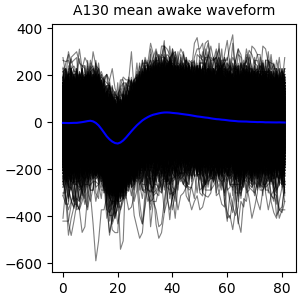

In [106]:
fig, ax = plt.subplots(figsize=(3, 3), constrained_layout=True)
ax.plot(waveform_array[:, aunit.peak_ch, :].T, color='k', linewidth=0.8, alpha=0.5)
ax.plot(awake_mean_waveform, color='b', linewidth=1.5)
ax.set_title('{} mean awake waveform'.format(aunit.unit_id))

Find spike times during anesthesia spontaneous period

In [107]:
iso_spike_samples = aunit_spike_samples[np.nonzero((aunit_spike_times > iso_maintenance[0]) & (aunit_spike_times < stim_log.onset.values[0]))[0]]
print(len(iso_spike_samples))
waveform_array = np.zeros((len(iso_spike_samples), exp.ephys_params[aunit.probe]['num_chs'], samples_per_spike))
for ii, spikeind in enumerate(iso_spike_samples):
    ap_start_ind = int(spikeind-pre_samples)
    waveform_array[ii,:,:] = rawAP[ap_start_ind:ap_start_ind+samples_per_spike, :].T
iso_mean_waveform = np.mean(waveform_array[:, aunit.peak_ch, :], axis=0)

1070


Text(0.5, 1.0, 'A130 mean iso waveform')

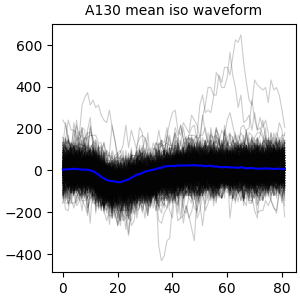

In [116]:
fig, ax = plt.subplots(figsize=(3, 3), constrained_layout=True)
ax.plot(waveform_array[:, aunit.peak_ch, :].T, color='k', linewidth=0.8, alpha=0.2)
ax.plot(iso_mean_waveform, color='b', linewidth=1.5)
ax.set_title('{} mean iso waveform'.format(aunit.unit_id))

Find estim spike times

In [114]:
choose_event = 8
eventrow = simple_log.iloc[choose_event]
print('Event {:d}: {}, {:d} uA'.format(choose_event, eventrow.stim_type, eventrow.parameter))

estim_spike_samples = aunit_spike_samples[np.nonzero((aunit_spike_times > eventrow.onset) & (aunit_spike_times < eventrow.offset))[0]]
print(len(estim_spike_samples))

waveform_array = np.zeros((len(estim_spike_samples), exp.ephys_params[aunit.probe]['num_chs'], samples_per_spike))
for ii, spikeind in enumerate(estim_spike_samples):
    ap_start_ind = int(spikeind-pre_samples)
    waveform_array[ii,:,:] = rawAP[ap_start_ind:ap_start_ind+samples_per_spike, :].T
estim_mean_waveform = np.mean(waveform_array[:, aunit.peak_ch, :], axis=0)

Event 8: freq50Hz, 70 uA
433


Text(0.5, 1.0, 'A130 mean estim waveform')

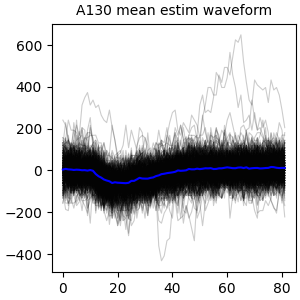

In [115]:
fig, ax = plt.subplots(figsize=(3, 3), constrained_layout=True)
ax.plot(waveform_array[:, aunit.peak_ch, :].T, color='k', linewidth=0.8, alpha=0.2)
ax.plot(estim_mean_waveform, color='b', linewidth=1.5)
ax.set_title('{} mean estim waveform'.format(aunit.unit_id))

## Plot an event

In [30]:
simple_log

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,10,20,1401.91070,1421.91083,0
1,freq50Hz,20,20,1524.83939,1544.83952,0
2,freq50Hz,30,20,1675.01610,1695.01623,0
3,freq50Hz,40,20,1821.29232,1841.29245,0
4,freq50Hz,40,40,1967.67782,2007.67808,0
5,freq50Hz,50,20,2151.04644,2171.04657,0
6,freq50Hz,50,40,2317.26693,2357.26717,0
7,freq50Hz,60,20,2500.46533,2520.46545,0
8,freq50Hz,70,20,2616.89479,2636.89491,0
9,freq50Hz,80,20,2729.82390,2749.82401,0


In [31]:
stim_log.head()

,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
0,freq50Hz,0,biphasic,10,1401.9107,1401.9111,0.0004,0
1,freq50Hz,0,biphasic,10,1401.9307,1401.9311,0.0004,0
2,freq50Hz,0,biphasic,10,1401.9507,1401.9511,0.0004,0
3,freq50Hz,0,biphasic,10,1401.9707,1401.9711,0.0004,0
4,freq50Hz,0,biphasic,10,1401.9907,1401.9911,0.0004,0


In [111]:
choose_event = 12
eventrow = simple_log.iloc[choose_event]
print(eventrow)
event_stims = stim_log[stim_log['event_ID'] == choose_event]
event_stims.head()

stim_type      freq50Hz
parameter           100
duration             20
onset        3148.72092
offset       3168.72103
sweep                 0
Name: 12, dtype: object


,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
15000,freq50Hz,12,biphasic,100,3148.72091,3148.72131,0.0004,0
15001,freq50Hz,12,biphasic,100,3148.74091,3148.74131,0.0004,0
15002,freq50Hz,12,biphasic,100,3148.76091,3148.76131,0.0004,0
15003,freq50Hz,12,biphasic,100,3148.78091,3148.78131,0.0004,0
15004,freq50Hz,12,biphasic,100,3148.80091,3148.80131,0.0004,0


[Text(0, 0, ''), Text(0, 4, ''), Text(0, 62, ''), Text(0, 212, '')]

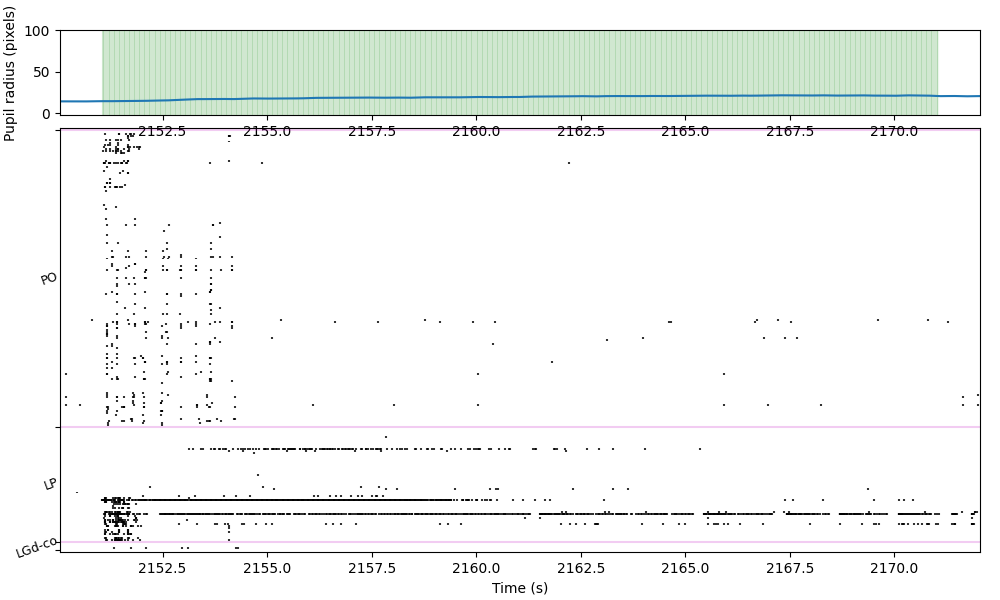

In [44]:
pdelta = 1. # plot before and after, s
pwindow = [eventrow.onset - pdelta, eventrow.offset + pdelta]
plot_regions = np.unique(THunitdf['region'].values)

fig = plt.figure(figsize=(10, 6)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.06, right=0.98, top=0.95, bottom=0.08, hspace=0.05, height_ratios=[1,5])
aax = fig.add_subplot(gs[0])
rasterax = fig.add_subplot(gs[1], sharex=aax)

## Plot pupil ##
pupilinds = np.nonzero((pupilts > pwindow[0]) & (pupilts < pwindow[1]))[0]
aax.axvspan(eventrow.onset, eventrow.offset, color='g', alpha=0.05)
# aax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.05)
# aax.axhline(awake_pupil_mean, color='b', linestyle='dashed', alpha=0.2)
for si, stimi in event_stims.iterrows():
    aax.axvline(stimi.onset, color='g', linewidth=0.5, alpha=0.2)
aax.plot(pupilts[pupilinds], sm_pupil[pupilinds])
aax.set_xlim(pwindow)
aax.set_ylim([-2, 100])
# aax.set_xlabel('Time (s)')
aax.set_ylabel('Pupil radius (pixels)')

## Plot raster ##
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwindow[0]) & (uspiketimes < pwindow[1]))[0]
        ]
        rasterax.eventplot(SWDspikes, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(pwindow[0], last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwindow)
rasterax.set_xlabel('Time (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
# fig_name = 'spont_EEG_NPX_{:d}-{:d}s.png'.format(int(window[0]), int(window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

Investigate single units: raster plots and waveforms

In [40]:
print(np.unique(THunitdf['region'].values))

['LGd-co' 'LP' 'PO']


In [42]:
THnuc = THunitdf[THunitdf['region'] == 'LP']
THnuc.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region
642,E160,probeE,90,2600,0.563149,LP,294,132,161,1.718165,0.91,1.981232,0.500000,11341,TH
644,E162,probeE,92,2580,0.521943,LP,294,131,161,1.073834,0.52,0.393952,0.003268,7088,TH
645,E163,probeE,93,2580,0.576884,LP,294,131,161,2.359466,0.83,3.498602,0.500000,15574,TH
646,E164,probeE,93,2580,0.508208,LP,294,131,161,0.860067,0.85,1.919124,0.003744,5677,TH
647,E165,probeE,93,2580,0.508208,LP,294,131,161,1.278965,0.92,2.152295,0.005270,8442,TH


In [112]:
choose_event = 12
eventrow = simple_log.iloc[choose_event]
print(eventrow)
event_stims = stim_log[stim_log['event_ID'] == choose_event]
event_stims.head()

stim_type      freq50Hz
parameter           100
duration             20
onset        3148.72092
offset       3168.72103
sweep                 0
Name: 12, dtype: object


,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
15000,freq50Hz,12,biphasic,100,3148.72091,3148.72131,0.0004,0
15001,freq50Hz,12,biphasic,100,3148.74091,3148.74131,0.0004,0
15002,freq50Hz,12,biphasic,100,3148.76091,3148.76131,0.0004,0
15003,freq50Hz,12,biphasic,100,3148.78091,3148.78131,0.0004,0
15004,freq50Hz,12,biphasic,100,3148.80091,3148.80131,0.0004,0


In [56]:
eventwindow = [eventrow.onset, eventrow.offset]
for indi, urow in THnuc.iterrows():
    uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
    stimspikes = uspiketimes[np.nonzero((uspiketimes > eventwindow[0]) & (uspiketimes < eventwindow[1]))[0]]
    print('Unit {} ({:d}): {:d} event spikes'.format(urow.unit_id, indi, len(stimspikes)))

NameError: name 'THnuc' is not defined

Plot a raster of an event

(0.0, 999.0)

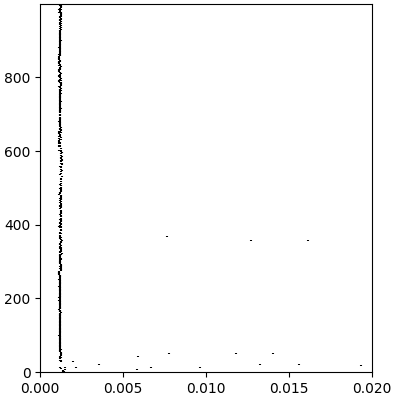

In [113]:
uind = 90
aunit = unit_info.iloc[uind]
# print(aunit)
aspiketimes = all_unit_all_spikes[aunit.unit_id]['spikes']

fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
rasterwin = 1/int(event_stims.iloc[0].event_type[event_stims.iloc[0].event_type.find('q')+1:event_stims.iloc[0].event_type.find('Hz')])
for ei, eonset in enumerate(event_stims.onset.values):
    spikemask = (aspiketimes > eonset) & (aspiketimes < eonset + rasterwin)
    stimspikes = aspiketimes[spikemask] - eonset
    ax.eventplot(stimspikes, lineoffsets=ei, linelengths=1.5, color='black')
ax.set_xlim([0, rasterwin])
ax.set_ylim([0, ei])

Plot the mean waveform

In [40]:
probe_waveforms = np.load(exp.ephys_params[aunit.probe]['waveforms'])
print(probe_waveforms.shape)

(383, 384, 82)


Text(0.5, 1.0, 'E182 mean waveform')

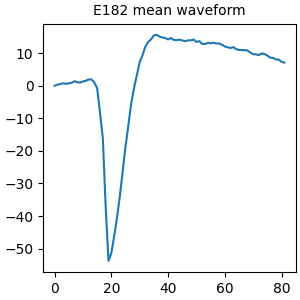

In [41]:
fig, ax = plt.subplots(figsize=(3, 3), constrained_layout=True)
ax.plot(probe_waveforms[int(aunit.unit_id[1:]), aunit.peak_ch, :])
ax.set_title('{} mean waveform'.format(aunit.unit_id))